# Tree of hydrolase 2090 homologs in Halobacteria and Nitrososphaeria

General approach:

- Load hydrolase 2090 homologs (*)
- Load GTDB archaeal tree (ar53 tree from release 214)
- Extract two GTDB class subtrees: Halobacteria and Nitrososphaeria
- Annotate entries homologous to A/B hydrolase 2090 from _Haloferax S5a-1_

(*) only considering entries present in our balanced subset of [GTDB (release 214)](https://gtdb.ecogenomic.org/) nicknamed `db_proka` ([Strock et al., 2024](https://doi.org/10.1101/2024.09.18.613068)).<br>Linking protein IDs from the wider GTDB to their NCBI accession is surprinsingly difficult.<br>In any case, GTDB only includes one representative per species in the tree.

In [42]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio import Phylo

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

from src.tree.tree_util import prune_leaves_with_unknown_id
from src.tree.itol_annotation import itol_labels, itol_color_strip_annotations, itol_binary_annotations
from src.utils.palette import palette_20

In [43]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

data_folder = Path('./data')
assert data_folder.is_dir()

## Load hydrolase 2090 homologs

In [30]:
hits = pd.read_csv(data_folder / 'hydrolase_search' / 'search_output.csv')

db_proka_hits = hits[hits['db_proka_id'].notnull()].copy()
db_proka_hits['assembly_accession'] = db_proka_hits['db_proka_id'].apply(lambda v: v.split('@')[1])

n = len(db_proka_hits)
total = len(hits)
percent = 100 * n / total

print(f'Number of hits present in our internal DB Proka (subset of GTDB 214): {n:,} ({percent:.0f}%)')

db_proka_hits.head()

Number of hits present in our internal DB Proka (subset of GTDB 214): 191 (38%)


,id,gtdb_id,db_proka_id,uniprot_id,domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus,...,ncbi_class,ncbi_order,ncbi_family,ncbi_genus,ncbi_species,tstart,tend,evalue,bits,assembly_accession
1,M0GTD3,NZ_AOLI01000034.1_29,WP_007545272.1@GCF_000336955.1,M0GTD3,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Haloferax,...,Halobacteria,Haloferacales,Haloferacaceae,Haloferax,Haloferax larsenii,1,290,7.391000e-185,581,GCF_000336955.1
5,I3R2Q4,NC_017941.2_785,WP_004057439.1@GCF_000306765.2,I3R2Q4,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Haloferax,...,Halobacteria,Haloferacales,Haloferacaceae,Haloferax,Haloferax mediterranei,1,290,3.791000e-139,449,GCF_000306765.2
8,A0A371N295,NZ_AOLJ01000011.1_106,WP_004972615.1@GCF_000336775.1,A0A371N295,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Haloferax,...,Halobacteria,Haloferacales,Haloferacaceae,Haloferax,Haloferax sp. Atlit-6N,1,290,5.312000e-136,440,GCF_000336775.1
11,A0A371LK82,NZ_AOLG01000009.1_386,WP_008092295.1@GCF_000336815.1,A0A371LK82,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Haloferax,...,Halobacteria,Haloferacales,Haloferacaceae,Haloferax,Haloferax sp. Atlit-16N,1,290,6.602000e-135,437,GCF_000336815.1
12,WP_058828042.1@GCF_001482285.1,NZ_LOEP01000032.1_74,WP_058828042.1@GCF_001482285.1,NaN,Archaea,Halobacteriota,Halobacteria,Halobacteriales,Haloferacaceae,Haloferax,...,NaN,NaN,NaN,NaN,NaN,1,290,4.818000e-135,437,GCF_001482285.1


In [4]:
n_archaea = len(db_proka_hits[db_proka_hits['domain'] == 'Archaea'])
print(f'Number of archaeal hits: {n_archaea:,}')

Number of archaeal hits: 180


## Load archaeal tree from GTDB (release 214)

In [5]:
gtdb_metadata = pd.read_csv(data_folder / 'GTDB_214.1' / 'db_proka_metadata.csv.gz', index_col='ncbi_accession')

In [6]:
halo_genomes = gtdb_metadata[gtdb_metadata['gtdb_class'] == 'Halobacteria'].copy()
halo_genome_accessions = set(halo_genomes.index)

thermo_genomes = gtdb_metadata[gtdb_metadata['gtdb_class'] == 'Nitrososphaeria'].copy()
thermo_genomes_accessions = set(thermo_genomes.index)

In [7]:
archaeal_tree = Phylo.read(data_folder / 'GTDB_214.1' / 'db_proka_ar53.tree', 'phyloxml')

# Remove prefix GB_ or RS_ from accession
for leaf in archaeal_tree.get_terminals():
    accession = leaf.name[3:]
    leaf.name = accession

halo_tree = prune_leaves_with_unknown_id(archaeal_tree, halo_genome_accessions)
halo_tree_accessions = sorted([l.name for l in halo_tree.get_terminals()])

thermo_tree = prune_leaves_with_unknown_id(archaeal_tree, thermo_genomes_accessions)
thermo_tree_accessions = sorted([l.name for l in thermo_tree.get_terminals()])

Phylo.write([halo_tree], data_folder / 'halo_nitro_tree' / 'Halobacteria.tree', 'phyloxml');
Phylo.write([thermo_tree], data_folder / 'halo_nitro_tree' / 'Nitrososphaeria.tree', 'phyloxml');

## Annotations

In [17]:
annotations_data = [
    ('halo', halo_genomes, halo_tree_accessions), 
    ('nitro', thermo_genomes, thermo_tree_accessions)
]

### Labels

In [18]:
for prefix, df, accessions in annotations_data:
    labels = []
    for accession in accessions:
        name = df.loc[accession, 'gtdb_species']
        labels.append([accession, name])

    itol_labels(labels, data_folder / 'halo_nitro_tree' / 'annotations' / f'{prefix}_labels.txt')

### GTDB family colour strip

In [15]:
families = (
    sorted(gtdb_metadata[
        gtdb_metadata['gtdb_class'] == 'Halobacteria'
    ]['gtdb_family'].unique()) +
    sorted(gtdb_metadata[
        gtdb_metadata['gtdb_class'] == 'Nitrososphaeria'
    ]['gtdb_family'].unique())
)

def is_named(s):
    if re.match(r'^[A-Z0-9\-_]+$', s) is not None:
        return False
    elif re.match(r'^.*[0-9]+.*$', s) is not None:
        return False
    else:
        return True

named_families = [f for f in families if is_named(f)]
named_families

family_to_colour = {f: palette_20[i] for i, f in enumerate(named_families)}
unamed_colour = '#a9a9a9'

In [21]:
for prefix, df, accessions in annotations_data:
    family_data = []
    for accession in accessions:
        gtdb_family = df.loc[accession, 'gtdb_family']
        colour = family_to_colour.get(gtdb_family, unamed_colour)
        family_data.append([accession, colour, gtdb_family])

    itol_color_strip_annotations(
        data=family_data,
        output_path=data_folder / 'halo_nitro_tree' / 'annotations' / f'{prefix}_family.txt',
        dataset_label='GTDB family',
        legend_title='GTDB family',
        color_branches=True,
    )

### Flag homologs of hydrolase 2090

In [38]:
homolog_accessions = set(db_proka_hits['assembly_accession'].unique())
for prefix, _, accessions in annotations_data:
    # Find maximum number of homolog in a single genome
    max_n_homologs = db_proka_hits[
        db_proka_hits['assembly_accession'].isin(accessions)
    ][['assembly_accession', 'id']].groupby('assembly_accession').nunique().max()['id']

    homologs_data = []
    for accession in accessions:
        if accession in homolog_accessions:
            n = len(db_proka_hits[db_proka_hits['assembly_accession'] == accession])
            label_list = ['1'] * n + ['-1'] * (max_n_homologs - n)
        else:
            label_list = ['-1'] * max_n_homologs

        homologs_data.append([accession] + label_list)

    itol_binary_annotations(
        data=homologs_data,
        output_path=data_folder / 'halo_nitro_tree' / 'annotations' / f'{prefix}_homologs.txt',
        field_shapes=[1] * max_n_homologs,
        field_labels=[f'{i+1} homolog{"s" if i > 0 else ""}' for i in range(max_n_homologs)],
        dataset_label='2090 homologs',
        field_colors=['#000075'] * max_n_homologs,
        legend_title='Homolog of hydrolase 2090',
    )

## Haladaptatus drilldown

Why so many homologs?

In [41]:
gtdb_metadata[gtdb_metadata['gtdb_family'].isin(named_families)][['gtdb_family', 'genome_size']]

,gtdb_family,genome_size
ncbi_accession,,
GCA_000200715.1,Nitrosopumilaceae,2045086
GCA_000204585.1,Nitrosopumilaceae,1772718
GCA_000224475.1,Haloferacaceae,3643158
GCA_000336895.1,Haloarculaceae,4147107
GCA_000337115.1,Natrialbaceae,3895275
...,...,...
GCF_900167955.1,Nitrosopumilaceae,1553159
GCF_900177045.1,Nitrosopumilaceae,1972585
GCF_900215575.1,Natronoarchaeaceae,3164179


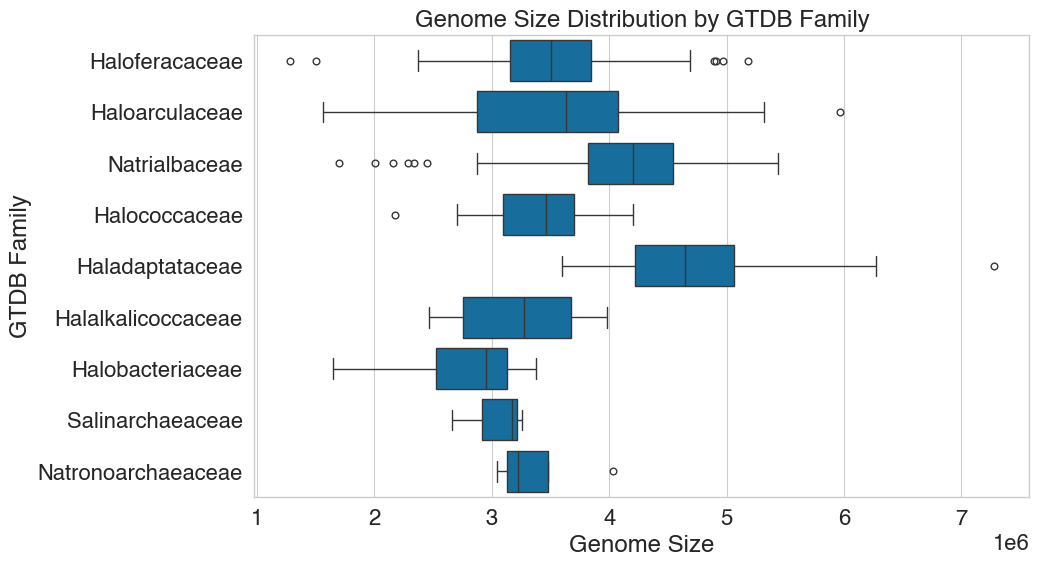

In [48]:
f = plt.figure(figsize=(10, 6))
df = gtdb_metadata[
    (gtdb_metadata['gtdb_class'] == 'Halobacteria') &
    gtdb_metadata['gtdb_family'].isin(named_families)
]
ax = sns.boxplot(data=df, x="genome_size", y="gtdb_family", orient="h")
ax.set_title('Genome Size Distribution by GTDB Family')
ax.set_xlabel('Genome Size');
ax.set_ylabel('GTDB Family');